In [1]:
!pip install fastai==1.0.11
!pip install ../input/spacy_model_en/en_core_web_sm-2.0.0.tar.gz
!python -m spacy link en_core_web_sm en
from fastai import *
from fastai.text import *
from tensorboard_cb import *

Processing /floyd/input/spacy_model_en/en_core_web_sm-2.0.0.tar.gz
    100% |████████████████████████████████| 614kB 8.2MB/s 
  Running setup.py bdist_wheel for en-core-web-sm ... done
  Stored in directory: /root/.cache/pip/wheels/4a/17/23/da236a6b4b6deb584a9d506a0e4af2303f581106e5e91c2e64
  Running setup.py bdist_wheel for regex ... done
  Stored in directory: /root/.cache/pip/wheels/74/17/3f/c77bba99efd74ba1a19862c9dd97f4b6d735e2826721dc00ff
Successfully built en-core-web-sm regex
  Found existing installation: regex 2017.4.5
    Uninstalling regex-2017.4.5:
      Successfully uninstalled regex-2017.4.5

    Linking successful
    /usr/local/lib/python3.6/site-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



# Text example

An example of creating a language model and then transfering to a classifier.

In [34]:
def read_csv_with_sample_size(path, sample_size, chunksize=24000):
    total_rows = get_total_length(path, chunksize=chunksize)
    chunk_length = get_chunk_length(path, chunksize=chunksize)
    # protect against zero
    sample_size = max(sample_size, 1)
    # protect against a fraction too small to sample from a chunk
    frac = min(max(sample_size, chunk_length+1) / total_rows, 1.0)
    df = pd.DataFrame()
    for chunk in pd.read_csv(path, chunksize=chunksize, header=None):
        df = pd.concat([df, chunk.sample(frac=frac)])
    return df[:sample_size]

In [37]:
!rm -rf data/
def build_directory_from_mounts(src='/floyd/input/imdb_reviews_wt103/', dst='data/', sample_size=1000):
    """
    Copy mounted directory into writable local, then save training language model csv with the specified sample_size
    """
    shutil.copytree(src, dst)
    dftr_lm = read_csv_with_sample_size(
        dst+'train.csv', sample_size=sample_size)
    dftr_lm.to_csv(dst+'train_lm.csv', index=False, header=False)

build_directory_from_mounts(sample_size=100)

In [38]:
dir_path = 'data/'
dftr_lm = pd.read_csv(dir_path+'train_lm.csv', header=None)
dftr_clas = pd.read_csv(dir_path+'train_clas.csv', header=None)
print(len(dftr_lm))
dftr_lm.head()

100


,0,1
0,0,It is a widespread superstition that when a bo...
1,0,"""Triloquist"" centers around a sister and broth..."
2,0,"I don't watch much bollywood movies, only a se..."
3,0,Here we have three interesting famous artists ...
4,0,...and I don't mean nuclear!! This movie is pr...


In [33]:
dftr_clas.head()

,0,1
0,0,The people who are praising this film are the ...
1,1,A kind of road movie in old-fashioned trains i...
2,0,We rented five movies for New Year's Eve weeke...
3,1,"Ok, basically this is a popcorn sci-fi movie, ..."
4,0,"I haven't seen ""Henry Fool"", but after watchin..."


Open and view the independent and dependent variables:

In [7]:
classes = read_classes(dir_path+'/classes.txt')[:2]
classes

['neg', 'pos']

Create a `DataBunch` for each of the language model and the classifier:

In [8]:
data_lm = TextLMDataBunch.from_csv(dir_path, train="train_lm")
data_clas = TextClasDataBunch.from_csv(dir_path, train='train_clas', valid='valid_clas', vocab=data_lm.train_ds.vocab)

Tokenizing train_lm.


Numericalizing train_lm.
Tokenizing valid.


Numericalizing valid.
Tokenizing train_clas.


Numericalizing train_clas.
Tokenizing valid_clas.


Numericalizing valid_clas.


We'll fine-tune the language model:

In [9]:
f'{len(dftr_lm)} rows', f'Vocabulary size: {data_lm.train_ds.vocab_size}'

('101 rows', 'Vocabulary size: 1288')

Total time: 03:10
epoch  train loss  valid loss  accuracy
1      9.557506    8.715771    0.119026  (03:10)



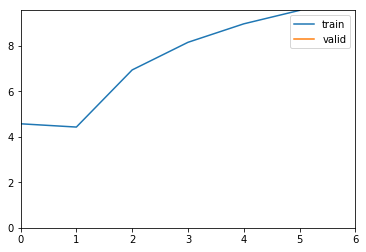

In [13]:
wd = 1e-7
lr=1e-3
lrs = lr
learn = RNNLearner.language_model(data_lm,drop_mult=0.7, pretrained_fnames=['lstm_wt103', 'itos_wt103'],metrics=accuracy,callback_fns=ShowGraph)
learn.fit_one_cycle(max_lr=slice(1e-3/2,1), wd=wd, cyc_len=1)

Save our language model's encoder:

In [14]:
learn.save_encoder(f'lm_last_ft')
learn.load_encoder(f'lm_last_ft')
learn.unfreeze()

In [21]:
learn.lr_find(start_lr=lrs/10, end_lr=lrs*10)
learn.recorder.plot()
plt.show()

Total time: 09:34
epoch  train loss  valid loss  accuracy
1      6.492668    4.965763    0.210325  (03:12)
2      5.857318    4.875619    0.210314  (03:10)
3      5.617917    4.825782    0.210316  (03:10)



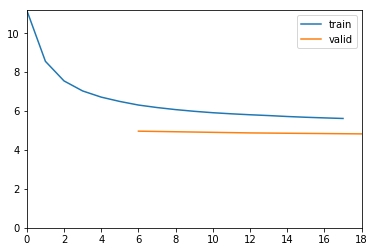

In [22]:
learn.fit(lr = slice(lrs, 1), wd=wd, epochs=15)

In [23]:
learn.recorder.metrics[0]

[0.21032450094820665]

In [15]:
learn.save_encoder('lm1_enc')

Fine tune it to create a classifier:

Total time: 11:24
epoch  train loss  valid loss  accuracy
1      0.694367    0.693478    0.500480  (11:23)



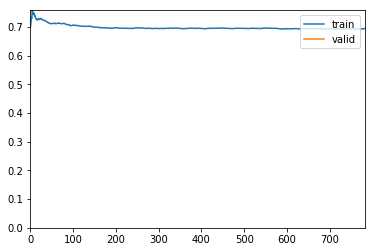

In [13]:
learn = RNNLearner.classifier(data_clas, drop_mult=0.5, clip=0.25, metrics=[accuracy],callback_fns=ShowGraph)
learn.load_encoder('lm1_enc')
learn.freeze_to(-1)

In [ ]:
wd = 1e-7
learn.lr_find(lrs/1000)
learn.fit(lr=slice(1e-4, 1e-2), wd=wd, epochs=1)
learn.save('clas_0')
learn.load('clas_0')
learn.freeze_to(-2)
learn.fit(lr=slice(1e-4, 1e-2), wd=wd, epochs=1)
learn.save('clas_1')
learn.load('clas_1')
learn.unfreeze()
learn.fit(lr=slice(1e-4, 1e-2), wd=wd, epochs=14)
learn.save('clas_2')

Total time: 08:59
epoch  train loss  valid loss  accuracy
1      0.695710    1.011420    0.500000  (08:59)



Total time: 11:26
epoch  train loss  valid loss  accuracy
1      0.694266    0.693202    0.500000  (11:26)



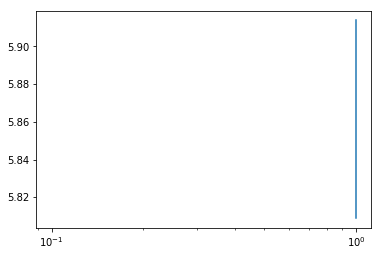

In [24]:
learn.recorder.plot()
plt.show()